In [1]:
import optuna
from sindy import *
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## Simulate Lorenz Attractor

In [2]:
# system parametera
sigma = 10.0
rho = 28.0
beta = 8/3
params = np.array([sigma, rho, beta])

# state => [x, y, z]
X0 = np.array([0, 1, 20])

# timesteps
n_steps = 10000
t = np.linspace(0, 50, n_steps)

# simulated states and timsteps data
X, t = simulate_lorenz_attractor(
    initial_state=X0, 
    timesteps=t, 
    params=params
)

X.shape, t.shape

((10000, 3), (10000,))

## Compute Derivatives Numerically

In [3]:
# numerically computed derivatives of system
numerical_derivatives = compute_derivatives(
    data=X, 
    timesteps=t,
    h=1
)

# actual derivatives of system
actual_derivatives = np.array([
    lorenz_ode(t, x, sigma, rho, beta) for t, x in zip(t, X)
])

## Simulaate and Add Periodic Control Input to the Lorenz System state space

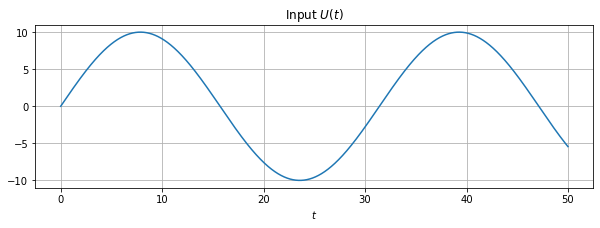

In [4]:
# periodic control input
U = 10 * np.sin(t / 5)
plt.figure(figsize=(10, 3))
plt.plot(t, U)
plt.title(r'Input $U(t)$')
plt.xlabel(r'$t$')
plt.grid()

In [5]:
# Add periodic control input to state matrix
X_U = np.concatenate([X, U.reshape(-1, 1)], axis=1)
X_U.shape

(10000, 4)

## Compute Polynomial Features

In [6]:
# polynomial features
X_poly = compute_poly_features(
    data=X_U,
    degree=2, 
    column_names=["X", "Y", "Z", "U"]
)

X_poly.head()

,1,X,Y,Z,U,X^2,X Y,X Z,X U,Y^2,Y Z,Y U,Z^2,Z U,U^2
0,1.0,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,0.000000,400.000000,0.000000,0.0000
1,1.0,0.048669,0.996014,19.735473,0.010001,0.002369,0.048475,0.960507,0.000487,0.992044,19.656811,0.009961,389.488892,0.197374,0.0001
2,1.0,0.094820,0.994065,19.474410,0.020002,0.008991,0.094257,1.846561,0.001897,0.988165,19.358823,0.019883,379.252628,0.389527,0.0004
3,1.0,0.138675,0.994160,19.217026,0.030003,0.019231,0.137865,2.664918,0.004161,0.988353,19.104791,0.029828,369.294092,0.576568,0.0009
4,1.0,0.180446,0.996305,18.963264,0.040004,0.032561,0.179779,3.421841,0.007219,0.992623,18.893192,0.039856,359.605388,0.758604,0.0016


## Define Data Scaler Object For scaling Data to a specific Range

In [7]:
# data scaler object
scaler = StandardScaler()

## Tune the relevant Hyper-parameters with Optuna

In [8]:
# hyper-parameter tuning space
alpha_space = (0.01, 0.5)
max_iter_space = (1000, 2000)
max_features_space = (3, 7)
n_cv = 10
threshold=-np.inf

# construct objective to find the best value of alpha max_iter and max_features
# that best minimize the 2 norm of the difference between the estimated 
# derivatives and the numerically computed derivatives.
objective = lambda trial: optimize_objective(
    trial=trial, 
    poly_features=X_poly.values, 
    derivatives=numerical_derivatives, 
    alpha_space=alpha_space, 
    max_iter_space=max_iter_space,
    max_features_space=max_features_space,
    n_cv=n_cv,
    threshold=threshold,
    scaler=scaler,
)

# create optuna study
study = optuna.create_study(
    study_name="SINDy",
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(),
    sampler=optuna.samplers.TPESampler(),
)

# optimize study objective
study.optimize(objective, n_trials=20)

[I 2023-02-28 13:18:22,965] A new study created in memory with name: SINDy
[I 2023-02-28 13:18:23,516] Trial 0 finished with value: 3124.671873325311 and parameters: {'alpha': 0.1733861880222396, 'max_iter': 1875, 'max_features': 3}. Best is trial 0 with value: 3124.671873325311.
[I 2023-02-28 13:18:23,917] Trial 1 finished with value: 488.78818228877196 and parameters: {'alpha': 0.35304057943284933, 'max_iter': 1847, 'max_features': 6}. Best is trial 1 with value: 488.78818228877196.
[I 2023-02-28 13:18:24,342] Trial 2 finished with value: 2946.573521548784 and parameters: {'alpha': 0.2786342352462426, 'max_iter': 1764, 'max_features': 5}. Best is trial 1 with value: 488.78818228877196.
[I 2023-02-28 13:18:24,759] Trial 3 finished with value: 2946.573521548784 and parameters: {'alpha': 0.22250455058413213, 'max_iter': 1256, 'max_features': 5}. Best is trial 1 with value: 488.78818228877196.
[I 2023-02-28 13:18:25,346] Trial 4 finished with value: 513.1999264800231 and parameters: {'al

## Compute Sparse Coefficients and Get Selected Features

In [9]:
# compute sparse coeffs and get features index
sindy_coeffs, selected_features = compute_linear_operator(
    poly_features=X_poly.values,
    derivatives=numerical_derivatives,
    alpha=study.best_trial.params["alpha"],
    max_iter=study.best_trial.params["max_iter"],
    max_features=study.best_trial.params["max_features"],
    n_cv=n_cv,
    threshold=threshold,
    scaler=scaler
)

BETA = sindy_coeffs.T.round(3)

In [10]:
# get relevant features
relevant_cols = X_poly.columns[selected_features]
X_prime = X_poly[relevant_cols]

# normalise data for visual validation
X_prime = scaler.fit_transform(X_prime)
actual_derivatives = scaler.fit_transform(actual_derivatives)
numerical_derivatives = scaler.fit_transform(numerical_derivatives)

print(
    f"alpha: {study.best_trial.params['alpha']} \n",
    f"max_iter: {study.best_trial.params['max_iter']} \n",
    f"max_features: {study.best_trial.params['max_features']}",
    f"Relevant Columns: \n{relevant_cols} \n\n", 
    f"Sparse Linear Operator: \n{BETA}",
)

alpha: 0.020420983799939924 
 max_iter: 1524 
 max_features: 7 Relevant Columns: 
Index(['X', 'Y', 'Z', 'X Y', 'X Z', 'Y Z', 'U^2'], dtype='object') 

 Sparse Linear Operator: 
[[-1.824e+00  3.314e+00 -1.000e-03]
 [ 2.084e+00 -1.320e-01  1.000e-03]
 [-0.000e+00 -0.000e+00 -2.900e-01]
 [-0.000e+00  0.000e+00  1.042e+00]
 [ 7.000e-03 -3.687e+00  1.000e-03]
 [-5.000e-03 -2.000e-03 -1.000e-03]
 [ 0.000e+00  0.000e+00  0.000e+00]]


## Use Computed Linear Operator (Sparse Coefficient) to Estimate derivatives

In [11]:
# estimate derivatives with linear combination
# of relevant features and sparse linear operator (beta)
estimated_derivatives = X_prime @ BETA

## Visualise and Compare Derivatives

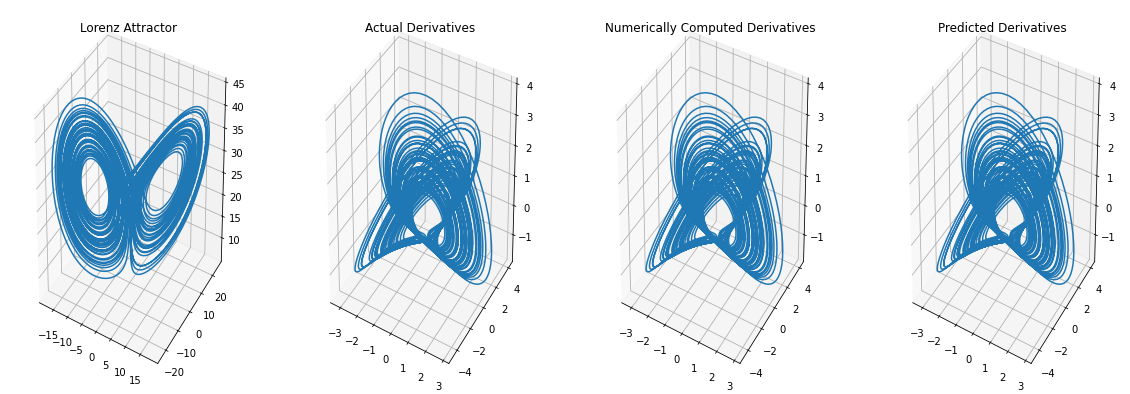

In [12]:
# plot data
fig, axs = plt.subplots(1, 4, figsize=(20, 7), subplot_kw=dict(projection='3d'))
axs[0].plot(X[:, 0], X[:, 1], X[:, 2])
axs[0].set_title(f"Lorenz Attractor")

axs[1].plot(actual_derivatives[:, 0], actual_derivatives[:, 1], actual_derivatives[:, 2])
axs[1].set_title("Actual Derivatives")

axs[2].plot(numerical_derivatives[:, 0], numerical_derivatives[:, 1], numerical_derivatives[:, 2])
axs[2].set_title("Numerically Computed Derivatives")

axs[3].plot(estimated_derivatives[:, 0], estimated_derivatives[:, 1], estimated_derivatives[:, 2])
axs[3].set_title("Predicted Derivatives")
plt.show()